In [ ]:
import os
import glob
import pywt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as torch_func
from operator import le, ge
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, roc_curve, classification_report, confusion_matrix, auc, roc_auc_score, \
multilabel_confusion_matrix

## Instructions

subject_number is one of the subfolders of the test subjects of the experiment, its range is 1-4.
For you to run the code, you need to make sure the attached "no-label-EMG-Physical-Action-Data-Set/sub{1-4}/Normal" (or Aggressive) folder tree is within the same place as the code. Then make sure to have the "model" folder tree as well.
Once you have that, you can just run the code.
Everything is gengeral enough for the code to run smoothly, for it to be faster, we've made the epoch 5, but the default is 50 (just for the early stop to be triggered).
The model should be saved and loaded automatically, depend on you taking the folder trees as mentioned.

In [ ]:
subject_number = "1"
normal_path = "no-label-EMG-Physical-Action-Data-Set/sub" + subject_number + "/Normal/"
aggressive_path = "no-label-EMG-Physical-Action-Data-Set/sub" + subject_number + "/Aggressive/"

normal_model_path = "model/normal/normal-model-" + subject_number + "-8.pth"
aggressive_model_path = "model/aggressive/aggressive-model-" + subject_number + "-8.pth"

def load_data(csv_dir, file_names, sign, threshold):
    x_train = pd.DataFrame()
    x_test = pd.DataFrame()
    y_train = pd.Series(dtype=int)
    y_test = pd.Series(dtype=int)

    counter = 0
    num_classes = 0

    for file_name in file_names:
        file_path = os.path.join(csv_dir, f"{file_name}.csv")
        previous_activity_dataframe = pd.read_csv(file_path)
        if sign(sum(previous_activity_dataframe.std()), threshold):
            num_classes += 1
            previous_activity_dataframe.dropna(inplace=True)
            train_test_split_ = int(len(previous_activity_dataframe) * 14/15)
            file_x_train = previous_activity_dataframe[:train_test_split_]
            file_x_test = previous_activity_dataframe[train_test_split_:]
            file_y_train = pd.Series([counter] * len(file_x_train))
            file_y_test = pd.Series([counter] * len(file_x_test))
            x_train = pd.concat([x_train, file_x_train], ignore_index=True)
            y_train = pd.concat([y_train, file_y_train], ignore_index=True)
            x_test = pd.concat([x_test, file_x_test], ignore_index=True)
            y_test = pd.concat([y_test, file_y_test], ignore_index=True)

            counter += 1

    return x_train, x_test, y_train, y_test, num_classes

normal_file_names = ['Bowing', 'Clapping', 'Handshaking', 'Hugging', 'Jumping', 'Running', 'Seating', \
'Standing', 'Walking', 'Waving']

aggressive_file_names = ['Elbowing', 'Frontkicking', 'Hamering', 'Headering', 'Kneeing', 'Pulling', 'Punching',\
'Pushing', 'Sidekicking', 'Slapping']

In [ ]:
# Define the transformer model class
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=256, num_heads=4, num_layers=6, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(hidden_dim, num_heads, \
                                                   dim_feedforward=hidden_dim*4, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.output_layer(x)

        return x

# Apply wavelet denoising to each input channel
def apply_wavelet_denoising(data, wavelet='sym4', level=2):
    coeffs = pywt.wavedec(data, wavelet=wavelet, level=level)
    threshold = np.sqrt(2 * np.log(len(data)))
    denoised_coeffs = [pywt.threshold(c, threshold) for c in coeffs]
    denoised_data = pywt.waverec(denoised_coeffs, wavelet=wavelet)
    return denoised_data

# Match the length of y_activities with filtered_data
def match_size(x, y):
    if len(x) > len(y):
        y = np.pad(y, (0, len(x) - len(y)), constant_values=y[0])
    elif len(x) < len(y):
        y = np.resize(y, len(x))

    return y

def apply_denoising_and_scaling(x_train, x_test, y_train, y_test):
    # Apply wavelet denoising to each feature in the DataFrame
    x_train = x_train.apply(apply_wavelet_denoising)
    x_test = x_test.apply(apply_wavelet_denoising)

    y_train = match_size(x_train, y_train)
    y_test = match_size(x_test, y_test)

    y_train = pd.Series(y_train, dtype=int)
    y_test = pd.Series(y_test, dtype=int)

    # Scale the input data
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Convert the training data and labels to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long).squeeze()

    # Define the batch size and create a DataLoader for the training data
    batch_size = 32

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, x_test, y_test

def start_training(model, model_path, train_dataloader, x_test, y_test, num_epochs=50):
    if model_path is not None and os.path.isfile(model_path):
        # Load model state from saved file
        model.load_state_dict(torch.load(model_path))

    # Define the loss function, optimizer, and metrics
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # Learning rate scheduler
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    # Train the model
    model.train()
    best_val_accuracy = 0.0
    patience = 5
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print("Starting epoch -", epoch + 1, "/", num_epochs)
        total_loss = 0.0
        train_total_samples = 0
        correct_predictions = 0

        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}', leave=False)
        for batch_inputs, batch_labels in progress_bar:
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(batch_labels)
            train_total_samples += len(batch_labels)
            predicted_labels = torch.argmax(outputs, dim=1)
            correct_predictions += (predicted_labels == batch_labels).sum().item()

            progress_bar.set_postfix({'loss': loss.item(),
                            'accuracy': (predicted_labels == batch_labels).sum().item() / len(batch_labels)})

        epoch_loss = total_loss / train_total_samples
        epoch_accuracy = correct_predictions / train_total_samples
        train_accuracies.append(epoch_accuracy)
        train_losses.append(epoch_loss)

        print("Epoch Loss -", epoch_loss)
        print("Epoch Accuracy -", epoch_accuracy)
        print("---------------------------------")

        # Update learning rate
        scheduler.step()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            x_val_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)
            y_val_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long).squeeze()
            val_outputs = model(x_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            val_losses.append(val_loss.item())
            val_predicted_labels = torch.argmax(val_outputs, dim=1)
            val_accuracy = accuracy_score(y_test, val_predicted_labels)
            val_accuracies.append(val_accuracy)

            # Save the best model
            if val_accuracy > best_val_accuracy:
                torch.save(model.state_dict(), model_path)
                best_val_accuracy = val_accuracy
                early_stop_counter = 0

            early_stop_counter += 1

            # Early stopping check
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

        model.train()

    if model_path is not None:
        torch.save(model.state_dict(), model_path)

    return train_accuracies, val_accuracies, train_losses, val_losses, model

def evaluate_model(model, model_path, x_test, y_test):
    # Load the best model checkpoint
    model.load_state_dict(torch.load(model_path))

    # Convert the test data to PyTorch tensors
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long).squeeze()

    # Evaluate the model on the test data
    model.eval()
    with torch.no_grad():
        test_outputs = model(x_test_tensor)
        predicted_labels = torch.argmax(test_outputs, dim=1)
        test_accuracy = accuracy_score(y_test, predicted_labels)
        test_precision = precision_score(y_test, predicted_labels, average=None)
        test_recall = recall_score(y_test, predicted_labels, average=None)
        test_f1 = f1_score(y_test, predicted_labels, average=None)

    print('Test Accuracy:', test_accuracy)
    print('Test Precision:', test_precision)
    print('Test Recall:', test_recall)
    print('Test F1-score:', test_f1)

    return test_outputs

In [ ]:
def train_and_val_accuracy_plot(train_accuracies, val_accuracies, fontsize=15):
    plt.figure(figsize=(15,10))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch', fontsize=fontsize)
    plt.ylabel('Accuracy', fontsize=fontsize)
    plt.title('Training and Validation Accuracy', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend()
    plt.show()

In [ ]:
def train_and_val_loss_plot(train_losses, val_losses, fontsize=15):
    plt.figure(figsize=(15,10))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch', fontsize=fontsize)
    plt.ylabel('Loss', fontsize=fontsize)
    plt.title('Training and Validation Loss', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend()
    plt.show()

In [ ]:
def model_roc_plot(test_outputs, y_test, fontsize=15):
    # Get the predicted probabilities for each class
    probabilities = torch.softmax(test_outputs, dim=1)
    probabilities = probabilities.detach().numpy()

    # Compute the macro-average ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1], pos_label=1)  # Assuming positive class is labeled as 1
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(15, 10))
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate', fontsize=fontsize)
    plt.ylabel('True Positive Rate', fontsize=fontsize)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend()
    plt.show()

In [ ]:
def classification_report_and_conffusion_matrix(test_outputs, y_test, num_classes):
    # Get the predicted labels
    predicted_labels = torch.argmax(test_outputs, dim=1).numpy()

    # Generate the classification report
    report = classification_report(y_test, predicted_labels)
    print('Classification Report:\n', report)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, predicted_labels)
    plt.figure(figsize=(15,10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:
# Normal Run

# Loading the data and divide it into train and test, and calculate the number of classes
normal_x_train, normal_x_test, normal_y_train, normal_y_test, normal_num_classes = \
                    load_data(normal_path, normal_file_names, le, 8000)

# Applying wavelet, fix lengths, convert into tensors and scaling the data
normal_train_dataloader, normal_x_test, normal_y_test = \
                    apply_denoising_and_scaling(normal_x_train, normal_x_test, normal_y_train, normal_y_test)

# Create an instance of the model
normal_input_dim = normal_x_train.shape[1]
normal_model = TransformerModel(normal_input_dim, normal_num_classes)

# Start the epoch loop and training the model
normal_train_accuracies, normal_val_accuracies, normal_train_losses, normal_val_losses, normal_model = \
    start_training(normal_model, normal_model_path, normal_train_dataloader, normal_x_test, normal_y_test, 5)

# evaluating the model
normal_test_outputs = evaluate_model(normal_model, normal_model_path, normal_x_test, normal_y_test)

Starting epoch - 1 / 5


Epoch Loss - 0.7749173131986408
Epoch Accuracy - 0.6630101278883489
---------------------------------
Starting epoch - 2 / 5


Epoch Loss - 0.6068718280455995
Epoch Accuracy - 0.7475630617176682
---------------------------------
Starting epoch - 3 / 5


Epoch Loss - 0.5627573295748397
Epoch Accuracy - 0.7677781096418583
---------------------------------
Starting epoch - 4 / 5


Epoch Loss - 0.4783998303830101
Epoch Accuracy - 0.8064432919710011
---------------------------------
Starting epoch - 5 / 5


Epoch Loss - 0.4618421830304683
Epoch Accuracy - 0.8127290993510549
---------------------------------
Test Accuracy: 0.8000379794910748
Test Precision: [0.89591078 0.91679749 0.78801843 0.9103139  0.9218107  0.67476852
 0.80446194 0.63013699]
Test Recall: [0.73363775 0.87556222 0.53354134 0.93548387 0.67166417 0.89830508
 0.91904048 0.82758621]
Test F1-score: [0.80669456 0.89570552 0.63627907 0.92272727 0.77710321 0.77065433
 0.85794262 0.71548931]


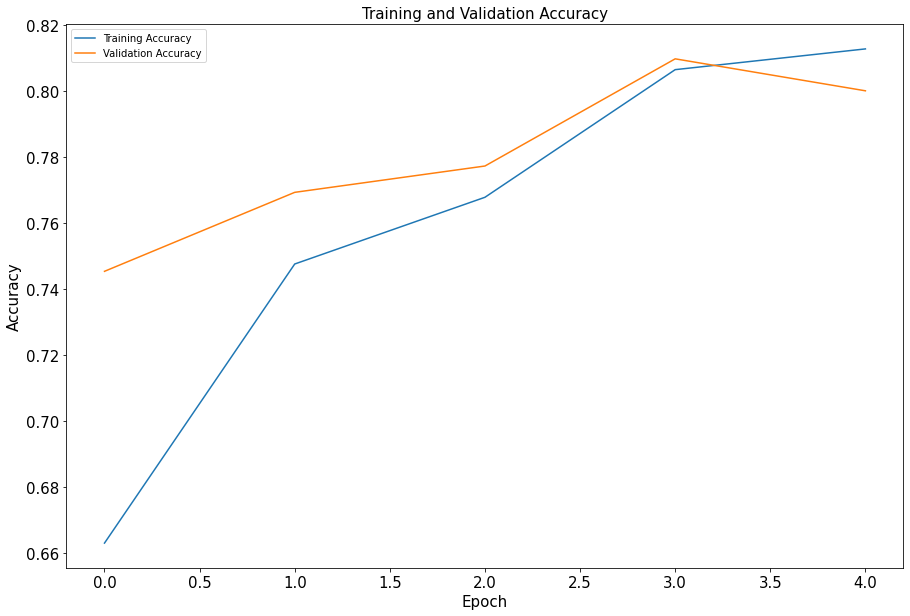

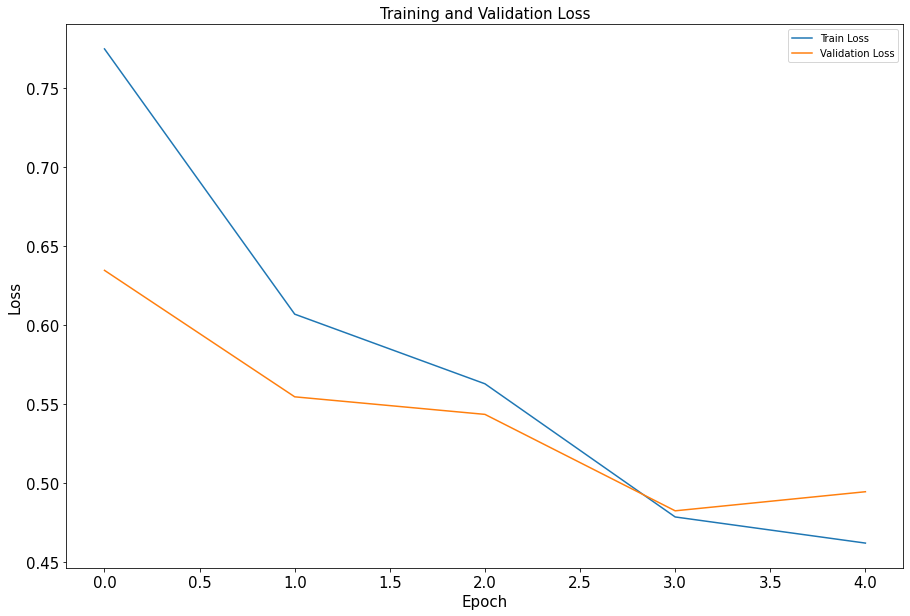

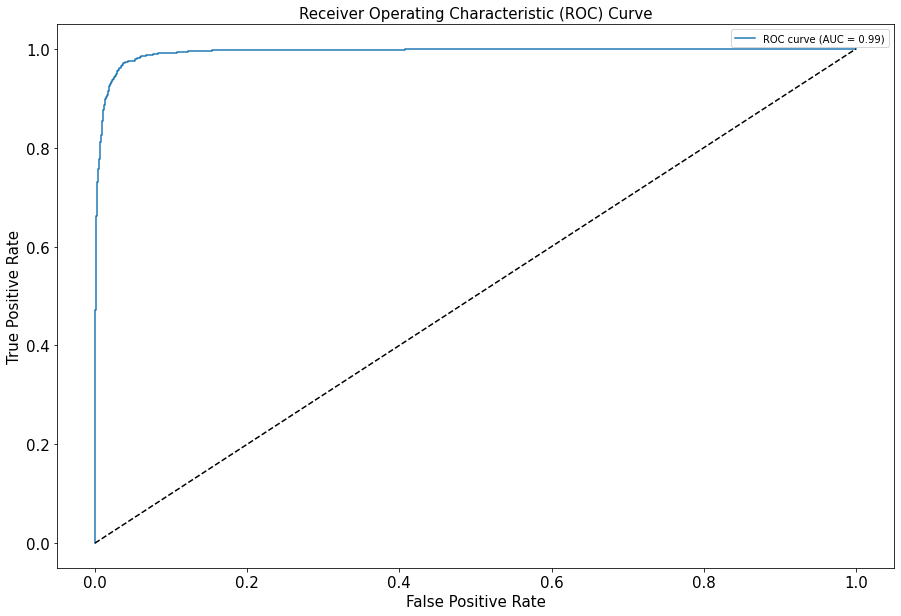

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.73      0.81       657
           1       0.92      0.88      0.90       667
           2       0.79      0.53      0.64       641
           3       0.91      0.94      0.92       651
           4       0.92      0.67      0.78       667
           5       0.67      0.90      0.77       649
           6       0.80      0.92      0.86       667
           7       0.63      0.83      0.72       667

    accuracy                           0.80      5266
   macro avg       0.82      0.80      0.80      5266
weighted avg       0.82      0.80      0.80      5266



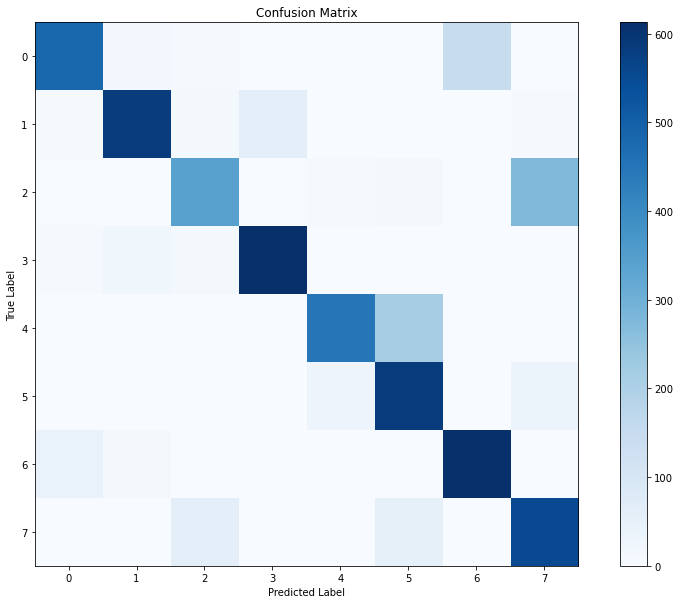

In [ ]:
# Normal Plots
train_and_val_accuracy_plot(normal_train_accuracies, normal_val_accuracies, 15)
train_and_val_loss_plot(normal_train_losses, normal_val_losses, 15)
model_roc_plot(normal_test_outputs, normal_y_test, 15)
classification_report_and_conffusion_matrix(normal_test_outputs, normal_y_test, normal_num_classes)

In [ ]:
# Aggressive Run

# Loading the data and divide it into train and test, and calculate the number of classes
aggressive_x_train, aggressive_x_test, aggressive_y_train, aggressive_y_test, aggressive_num_classes = \
        load_data(aggressive_path, aggressive_file_names, ge, 8000)

# Applying wavelet, fix lengths, convert into tensors and scaling the data
aggressive_train_dataloader, aggressive_x_test, aggressive_y_test = \
        apply_denoising_and_scaling(aggressive_x_train, aggressive_x_test, aggressive_y_train, aggressive_y_test)

# Create an instance of the model
aggressive_input_dim = aggressive_x_train.shape[1]
aggressive_model = TransformerModel(aggressive_input_dim, aggressive_num_classes)

# Start the epoch loop and training the model
aggressive_train_accuracies, aggressive_val_accuracies, aggressive_train_losses, aggressive_val_losses, \
    aggressive_model = start_training(aggressive_model, aggressive_model_path, aggressive_train_dataloader, \
                       aggressive_x_test, aggressive_y_test, 5)

# evaluating the model
aggressive_test_outputs = evaluate_model(aggressive_model, aggressive_model_path, \
                                         aggressive_x_test, aggressive_y_test)

Starting epoch - 1 / 5


Epoch Loss - 1.6870316460929646
Epoch Accuracy - 0.3448535666545145
---------------------------------
Starting epoch - 2 / 5


Epoch Loss - 1.5631103011871952
Epoch Accuracy - 0.3933163203305383
---------------------------------
Starting epoch - 3 / 5


Epoch Loss - 1.5069762376406775
Epoch Accuracy - 0.4157856361647831
---------------------------------
Starting epoch - 4 / 5


Epoch Loss - 1.4271693963126055
Epoch Accuracy - 0.44516952242070723
---------------------------------
Starting epoch - 5 / 5


Epoch Loss - 1.4103564846890855
Epoch Accuracy - 0.45255802649167576
---------------------------------
Test Accuracy: 0.44102651257647857
Test Precision: [0.47552448 0.29942857 0.43264659 0.26848249 0.58863636 0.39914163
 0.51866667 0.26648352 0.64039409]
Test Recall: [0.41653905 0.4        0.40929535 0.31034483 0.40217391 0.28926905
 0.60216718 0.14786585 0.99540582]
Test F1-score: [0.44408163 0.34248366 0.42064715 0.28789986 0.47785978 0.33543733
 0.55730659 0.19019608 0.7793765 ]


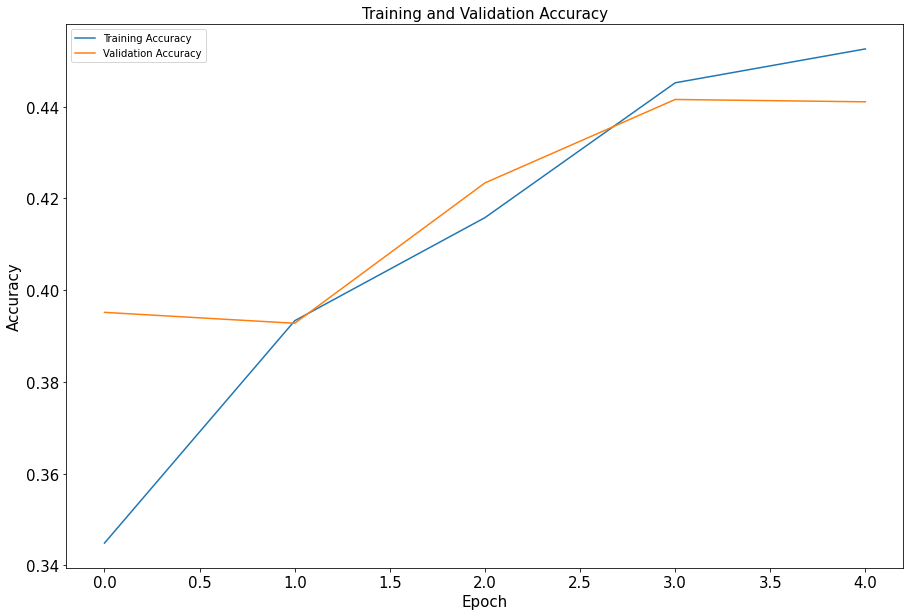

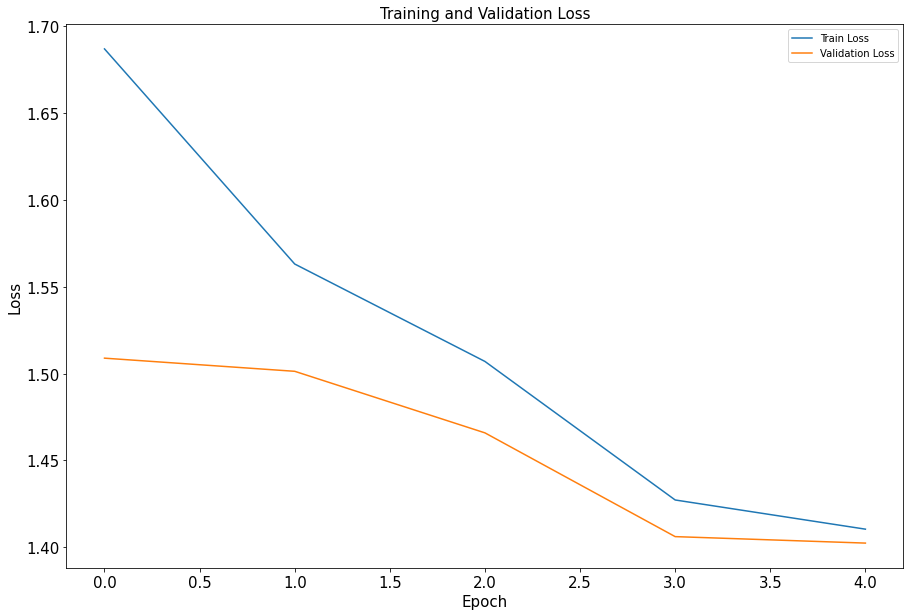

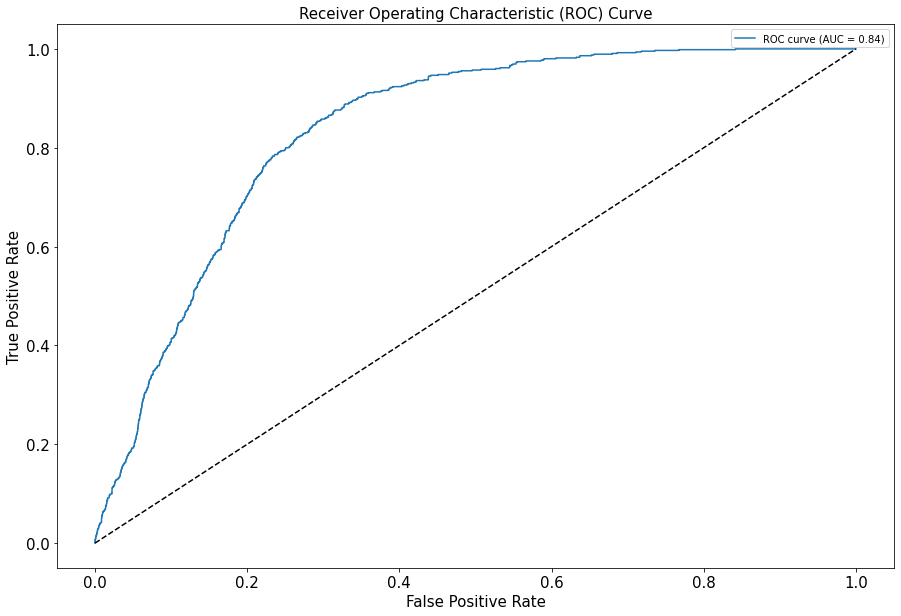

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.42      0.44       653
           1       0.30      0.40      0.34       655
           2       0.43      0.41      0.42       667
           3       0.27      0.31      0.29       667
           4       0.59      0.40      0.48       644
           5       0.40      0.29      0.34       643
           6       0.52      0.60      0.56       646
           7       0.27      0.15      0.19       656
           8       0.64      1.00      0.78       653

    accuracy                           0.44      5884
   macro avg       0.43      0.44      0.43      5884
weighted avg       0.43      0.44      0.43      5884



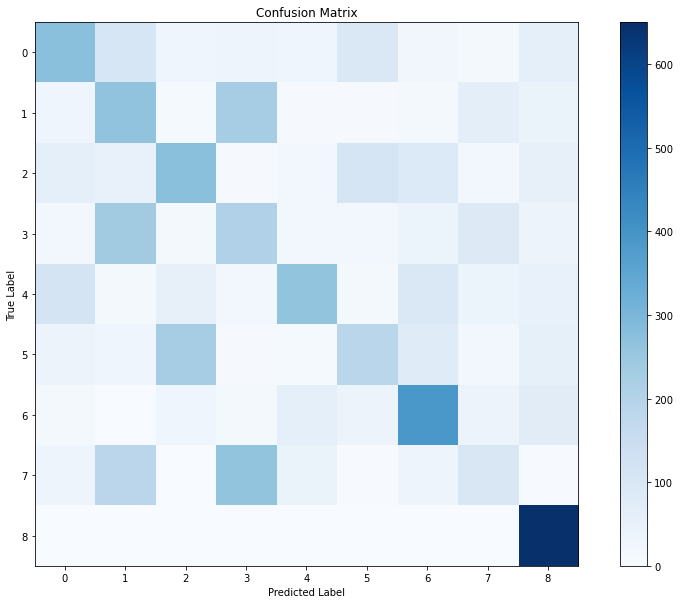

In [ ]:
# Aggressive Plots
train_and_val_accuracy_plot(aggressive_train_accuracies, aggressive_val_accuracies, 15)
train_and_val_loss_plot(aggressive_train_losses, aggressive_val_losses, 15)
model_roc_plot(aggressive_test_outputs, aggressive_y_test, 15)
classification_report_and_conffusion_matrix(aggressive_test_outputs, aggressive_y_test, aggressive_num_classes)